In [1]:
import functions_kinegeo
from functions_kinegeo import *

R[write to console]: data.table 1.13.6 using 12 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Lade nötiges Paket: bit

R[write to console]: 
Attache Paket: ‘bit’


R[write to console]: The following object is masked from ‘package:data.table’:

    setattr


R[write to console]: The following object is masked from ‘package:base’:

    xor


R[write to console]: Attaching package bit64

R[write to console]: package:bit64 (c) 2011-2017 Jens Oehlschlaegel

R[write to console]: creators: integer64 runif64 seq :

R[write to console]: coercion: as.integer64 as.vector as.logical as.integer as.double as.character as.bitstring

R[write to console]: logical operator: ! & | xor != == < <= >= >

R[write to console]: arithmetic operator: + - * / %/% %% ^

R[write to console]: math: sign abs sqrt log log2 log10

R[write to console]: math: floor ceiling trunc round

R[write to console]: querying: is.integer64 is.vector [is.atomic} [length] format print str

R[write t

In [2]:
# test whether prior works
kinegeo_prior_stats(p=6200,r=2000)

array([-63.42389743,  53.87836673,  -1.05965793,  37.41708628,
        -0.24596455])

/tmp/ipykernel_1127662/3042464378.py:35: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = float(r['pseudocolour'])


Gaia DR3 source_id: 3490289715508854016
HEALpixel level 5: 6200
Model of distance prior:  GGD

Geometric distance estimation:

w[mas] 0.9714660881660193
Zeropoint wzp [mas] -0.030804000000000005
Zeropointcorrected parallax w[mas] 1.0022700881660194
wsd/w 0.06940250860146781
alpha 0.231898384915402
beta 4.82522701498775
rlen [pc]: 0.00131482073400735

glon [deg] for HEALpixel 6200: 285.73584
glat [deg] for HEALpixel 6200: 34.80791

Estimated distances:

r_est [pc] (quantile 0.5): 1007.7035946382739
r_lo_est [pc] (quantile 0.159): 940.1748572295262
r_hi_est [pc] (quantile 0.841): 1085.7285762916426


MCMC initialization [pc]: 997.0009017351475
MCMC stepsize [pc]: 51.89577274375856
MCMC number of burn-in samples: 500
MCMC number of retained iterations: 5000


Velocity estimation:

proper motion ra [mas/yr]: -20.341311894388397
proper motion dec [mas/yr]: -4.659408150129683
proper motion ra error [mas/yr]: 0.07511591166257858
proper motion dec error [mas/yr]: 0.05103689059615135
parallax -

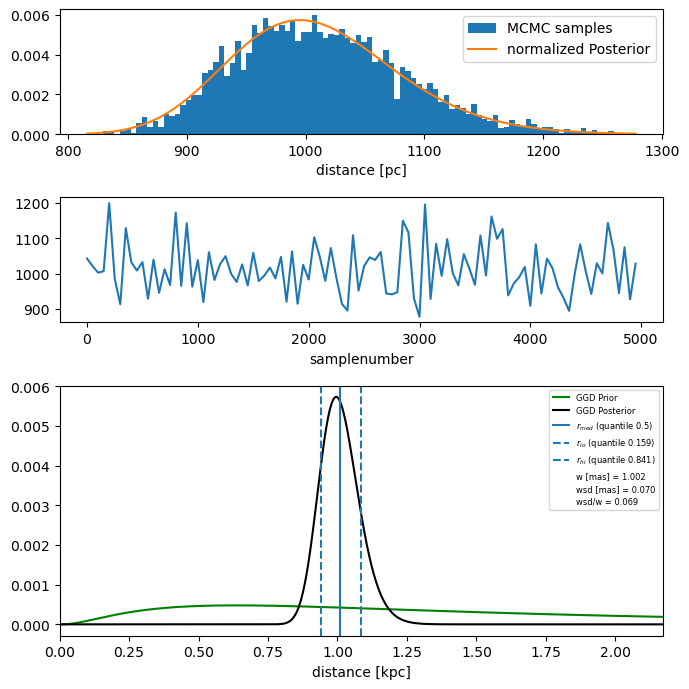

In [3]:
source_id = 3490289715508854016#3490289711213205632 #random star from Gaia DR3 of HP 6200
model = 'GGD'

# Settings for metropolis algorithm sampling the distance posterior; rInit, rStep calculated in code

Nsamp = int(5e3) #N_g 
Nburnin = int(5e2)

# Number of velocity samples drawn for each of the distance samples 

n = 1

#for quantiles

HDIprob = 0.6827
probs=np.array([0.5,(1-HDIprob)/2,(1+HDIprob)/2])

with open('prior_summary.csv', newline='') as prior_summary:
    reader_prior_summary = csv.reader(prior_summary)
    rows_prior_summary = []
    for row in reader_prior_summary:
        rows_prior_summary.append(row)


    job = Gaia.launch_job("select top 10 "
                                            "source_id, parallax, parallax_error,phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved,bp_rp,pmra,pmra_error,pmdec, pmdec_error,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr "
                                            "from gaiadr3.gaia_source "
                                            "where source_id={}".format(int(source_id)))
    r = job.get_results()
    
    w= float(r['parallax'])
    wsd = float(r['parallax_error'])   
    phot_g_mean_mag = float(r['phot_g_mean_mag'])
    nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'])
    pseudocolour = float(r['pseudocolour'])
    ecl_lat = float(r['ecl_lat'])
    astrometric_params_solved = float(r['astrometric_params_solved'])
    bp_rp = float(r['bp_rp'])
    
    mu_ra = float(r['pmra'])
    mu_dec = float(r['pmdec'])
    sd_mu_ra = float(r['pmra_error'])
    sd_mu_dec = float(r['pmdec_error'])
    corr_w_mu_ra = float(r['parallax_pmra_corr'])
    corr_w_mu_dec = float(r['parallax_pmdec_corr'])
    corr_mu_ra_dec = float(r['pmra_pmdec_corr'])
    
    source_id = int(r['source_id'])
    hp = math.floor(source_id / (2**(35)*4**(12-5)) )
    
    print('Gaia DR3 source_id:',source_id)
    print('HEALpixel level 5:',hp)
    print('Model of distance prior: ', model)
    print('')
    print('\033[1m' + 'Geometric distance estimation:' + '\033[0m')
    
    #Zeropoint:
                
    if astrometric_params_solved == 31 or astrometric_params_solved == 95:
        
        if  phot_g_mean_mag == np.nan:
            wzp = -0.017
                        
        else:
            wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)
                    
        #Correct for Zeropoint:
        w = w - wzp
                    
    if model == 'EDSD' or model == 'Photogeometric':
        rlen = float(rows_prior_summary[hp+1][10])  #EDSDrlen in csv-file
    if model == 'GGD':  
        rlen = float(rows_prior_summary[hp+1][5]) # GGDrlen in csv-file
            
    rlen_EDSD = float(rows_prior_summary[hp+1][10])      
    alpha = float(rows_prior_summary[hp+1][6])
    beta = float(rows_prior_summary[hp+1][7])
    glon = float(rows_prior_summary[hp+1][1])
    glat = float(rows_prior_summary[hp+1][2])
    
    rInit = float(mode_post3(w=1e-3*w,wsd=1e-3*wsd,rlen = rlen_EDSD,retall = False)) 
    rStep = 0.75*rInit*min(1/3, abs(wsd/w))
    
    
    # Convert inputs to arcsec       
    
    w = 1e-3*w
    wsd = 1e-3*wsd
    
    if astrometric_params_solved == 31 or astrometric_params_solved == 95:
        wzp = 1e-3*wzp
        
    if model == 'EDSD':
        failMessage = np.nan
        rQuant0 = quantile_distpost3(w=w,wsd=wsd,rlen=rlen,rInit=rInit,rStep=rStep,Nburnin=Nburnin,Nsamp=Nsamp,probs=np.array([0.5,0.159,0.841])) #(1-HDIprob)/2,(1+HDIprob)/2
        rQuant = rQuant0[0] #quantiles of distance 
        rSamp = rQuant0[1] #distance samples
        
    if model == 'GGD':
        failMessage = np.nan
        rQuant0 = quantile_distpost4(w=w,wsd=wsd,rlen=rlen,alpha=alpha,beta=beta,rStep=rStep,rInit=rInit,Nburnin=Nburnin,Nsamp=Nsamp,probs=np.array([0.5,0.159,0.841]))
        rQuant = rQuant0[0] #quantiles of distance 
        rSamp = rQuant0[1] #distance samples
        
    if model == 'Photogeometric':
        
        failMessage = np.nan
        rQuant0 = quantile_distpost5(w=w,wsd=wsd,hp=hp,phot_g_mean_mag=phot_g_mean_mag,bp_rp=bp_rp,pseudocolour=pseudocolour,rInit=rInit,Nsamp=Nsamp,Nburnin=Nburnin,probs=np.array([0.5,0.159,0.841]))
        rQuant = rQuant0[0] #quantiles of distance 
        rSamp = rQuant0[1] #distance samples
        
        # QGmodel (only for photogeometric output statistics):
        if rQuant['code'] == 1:
            rFlag = rQuant0[2]
            
    # if distance estimation works: get array with quantiles, otherwise array with nans     
    
    if rQuant['code'] == 1:
        rRes = np.array([rQuant['val'][0],rQuant['val'][1],rQuant['val'][2],2])
        
    else:
        
        failMessage = rQuant['message']
        
    if failMessage == rQuant['message']:
        
        rRes = np.empty((6,))
        rRes[:] = np.nan
        rRes = np.array([rRes[0],rRes[1],rRes[2],rRes[3],rRes[4],0])    
        rSamp = np.nan
        
    if type(failMessage) == str :
        
        print('')
        print(f"\033[1;31m {failMessage} \033[0m")
        print ('') 
        
    else:    
        #print parameters
        print('')
        if astrometric_params_solved == 31 or astrometric_params_solved == 95:
            print('w[mas]',1e3*(w+wzp))
            print('Zeropoint wzp [mas]', 1e3*wzp)
            print('Zeropointcorrected parallax w[mas]',1e3*w)
        else:
            print('w[mas]',1e3*w)
            print('no zeropoint correction, because astrometric_params_solved is not 31 or 95 ')
        print('wsd/w', wsd/w)
    
        if model == 'GGD' or model == 'Photogeometric':
            print('alpha',alpha)
            print('beta',beta)
        
        if model == 'Photogeometric':
            print('G',phot_g_mean_mag)
            print('colour bp-rp',bp_rp)
            
        print('rlen [pc]:', rlen)        
        print('')
        print(f'glon [deg] for HEALpixel {hp}:',glon)
        print(f'glat [deg] for HEALpixel {hp}:',glat)
        print('')
        print('Estimated distances:')
        print('')
        print('r_est [pc] (quantile 0.5):',rRes[0])
        print('r_lo_est [pc] (quantile 0.159):', rRes[1])
        print('r_hi_est [pc] (quantile 0.841):', rRes[2])
        print('')
        
        #print('result_flag', rRes[3]) 
        print('')
        print('MCMC initialization [pc]:', rInit)
        print('MCMC stepsize [pc]:',rStep)
        #print('MCMC Number of iterations[pc]:',Nsamp+Nburnin)
        print('MCMC number of burn-in samples:',Nburnin)
        print('MCMC number of retained iterations:',Nsamp)
        print('')
        
        if model == 'Photogeometric' and rQuant['code'] == 1:
            print('QGmodel:',rFlag[3])
        print('')
        
        # Plots----------------------------------------------------------------------------------------------------------------------- 
        
        #Range for normalizing Posterior

        rlo = 0
        rhi = 1e5
        
        #Plotting range: lower limit
        
        rplotlo = 0
        
        # set upper plotting limits on x-axis rplothi. If at least one of the estimated quantiles is nan: 5*rlen, otherwise 2*r_hi
                                    
        if np.isnan(rRes[0]) or np.isnan(rRes[1]) or np.isnan(rRes[2]) or np.isnan(rRes[3]) :
            rplothi = 5*rlen
        else:
            rplothi = 2*rRes[2]
                    
        samp = rQuant0[1]
        
        if not np.isnan(samp).all():
        
            fig,ax = plt.subplots(3,1,figsize=(7,7), gridspec_kw={'height_ratios': [1,1,2]})
            
            r1 = np.arange(0,len(samp))
            
            ax[1].plot(r1[::50],samp[::50])
            ax[1].set_xlabel('samplenumber')
            ax[0].hist(samp,bins=100,density=True,label='MCMC samples')
            r0 = np.linspace(min(samp),max(samp),num=100)
            
            Nplot = 1e3
            s = np.arange(1/(2*Nplot),1/Nplot*(Nplot+1),1/Nplot)
            rplot = s*(rplothi-rplotlo) + rplotlo
            
            #Normalization of the posterior and prior
            
            if model == 'EDSD':
                Z = scipy.integrate.quad(ud_distpost3,rlo,rhi,args=(w,wsd,rlen))[0]
                if not (Z == 0 or 1/Z == np.inf):
                    ax[0].plot(r0,ud_distpost3(r=r0,w=w,wsd=wsd,rlen=rlen)/Z,label='normalized Posterior')
                    dpost  = ud_distpost3(r=rplot, w=w, wsd=wsd, rlen=rlen)/Z
                dprior = (1/(2*rlen**3))*np.exp(-rplot/rlen)*rplot**2
                
                
            if model == 'GGD':
                Z = scipy.integrate.quad(ud_distpost4,rlo,rhi,args=(w,wsd,rlen,alpha,beta))[0]
                if not (Z == 0 or 1/Z == np.inf):
                    ax[0].plot(r0,ud_distpost4(r=r0,w=w,wsd=wsd,rlen=rlen,alpha=alpha,beta=beta)/Z,label='normalized Posterior')
                    dpost  = ud_distpost4(r=rplot, w=w, wsd=wsd, rlen=rlen,alpha=alpha,beta=beta)/Z
                dprior = 1/gamma((beta+1)/alpha)*alpha/(rlen**(beta+1))*rplot**beta*np.exp(-(rplot/rlen)**alpha)
                
            # with the photogeometric model, assume that the normalization factor of the posterior 1/Z is approximately 1/max(posterior)
            
            if model == 'Photogeometric':
                dpost = r_ud_distpost5_photogeo(r=rplot,parallax=w,parallax_error=wsd,p=hp,phot_g_mean_mag=phot_g_mean_mag,bp_rp=bp_rp,pseudocolour = pseudocolour)
                dpost = dpost/max(dpost)
                dprior = r_photogeo_dist_prior(r=rplot,rlen=rlen,beta=beta,alpha=alpha,p=hp,phot_g_mean_mag=phot_g_mean_mag,bp_rp=bp_rp,pseudocolour = pseudocolour)
                dprior = dprior/max(dprior)
                Z = max(dpost)
                
            ax[0].set_xlabel('distance [pc]')
            ax[0].legend()
            ax[2].plot(1e-3*rplot,dprior,color='green',label = f'{model} Prior' )
            ax[2].set_xlim([1e-3*rplotlo,1e-3*rplothi])
            ax[2].set_xlabel('distance [kpc]')
            if not (Z == 0 or 1/Z == np.inf):
                #ax[2].set_ylim([0,1.05*max(np.array([dprior,dpost]).flatten())])
                ax[2].plot(1e-3*rplot,dpost,color = 'black',label= f'{model} Posterior')
                
            ax[2].axvline(1e-3*rRes[0],label ='$r_{med}$ (quantile 0.5)')
            ax[2].axvline(1e-3*rRes[1], linestyle ='--',label='$r_{lo}$ (quantile 0.159)')
            ax[2].axvline(1e-3*rRes[2], linestyle ='--',label='$r_{hi}$ (quantile 0.841)')
            
            ax[2].plot([], [], ' ', label=f'w [mas] = {1e3*w:.3f}')
            ax[2].plot([], [], ' ', label=f'wsd [mas] = {1e3*wsd:.3f}')       
            ax[2].plot([], [], ' ', label=f'wsd/w = {wsd/w:.3f}')
            
            ax[2].legend(fontsize='6')
            
            fig.tight_layout()
    #----------------------------------------------------------------------------------------------------------------------------------------
    
    # kinegeometric velocity estimation:
    
    # Convert inputs back to mas, distance samples to kpc   
    
    w = 1e3*w
    wsd = 1e3*wsd
    rSamp = 1e-3*rSamp
    
    vRes = quantile_velpost(rSamp, n ,hp , probs, w,wsd,mu_ra, mu_dec,sd_mu_ra, sd_mu_dec,corr_w_mu_ra,corr_w_mu_dec,corr_mu_ra_dec)
    
    print('\033[1m' + 'Velocity estimation:' + '\033[0m')
    
    if isinstance(vRes, str):
        print('')
        print(f"\033[1;31m {vRes} \033[0m")
        print('')
    else:
        v_ra_res, v_dec_res, v_corr_res, Sigma_rv_ra, Sigma_rv_dec,velocitySamples_allr_mean = vRes
        
        #print summary statistics: 
        
        print('')
        print('proper motion ra [mas/yr]:',mu_ra)
        print('proper motion dec [mas/yr]:',mu_dec)
        print('proper motion ra error [mas/yr]:',sd_mu_ra)
        print('proper motion dec error [mas/yr]:',sd_mu_dec)
        print('parallax - proper motion ra correlation: ',corr_w_mu_ra)
        print('parallax - proper motion dec correlation: ',corr_w_mu_dec)
        print('proper motion ra-dec correlation: ',corr_mu_ra_dec)
        print('')
        print('Number of velocity samples drawn for each of the MCMC distance samples: ',n)
        print('')
        print('Estimated velocities:')
        print('')
        print('velocity in ra:')
        print('v_ra_est [km/s] (quantile 0.5): ', v_ra_res[0])
        print('v_ra_lo_est [km/s] (quantile 0.159): ',v_ra_res[1])
        print('v_ra_hi_est [km/s](quantile 0.841): ',v_ra_res[2])
        print('')
        print('velocity in dec:')
        print('v_dec_est [km/s] (quantile 0.5): ', v_dec_res[0])
        print('v_dec_lo_est [km/s] (quantile 0.159): ',v_dec_res[1])
        print('v_dec_hi_est [km/s](quantile 0.841): ',v_dec_res[2])
        print('')
        print('Correlation between v_ra and v_dec: ', v_corr_res[1,0])
        print('')
        print('Covariance between each velocity and distance:' )
        print('Sigma_rv_ra [kpc km/s]: ',Sigma_rv_ra )
        print('Sigma_rv_dec [kpc km/s]: ',Sigma_rv_dec )
        
        

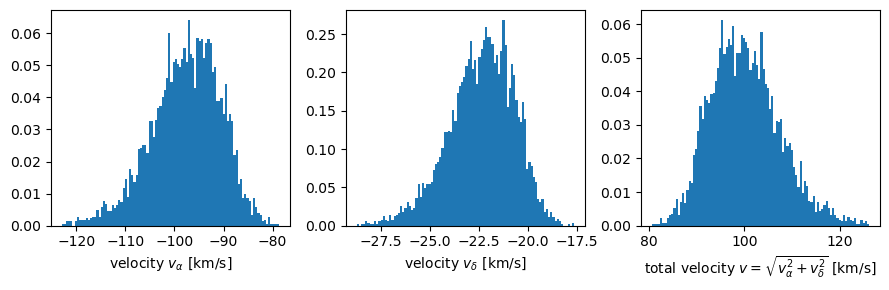

In [4]:
#plot velocity samples

fig,ax = plt.subplots(1,3,figsize=(9,3))

total_velocity_samples = np.sqrt(velocitySamples_allr_mean[:,0]**2+velocitySamples_allr_mean[:,1]**2)

ax[0].hist(velocitySamples_allr_mean[:,0],bins=100,density=True)
ax[1].hist(velocitySamples_allr_mean[:,1],bins=100,density=True)
ax[2].hist(total_velocity_samples,bins=100,density=True)


ax[0].set_xlabel('velocity $v_\\alpha$ [km/s]')
ax[1].set_xlabel('velocity $v_\delta$ [km/s]')
ax[2].set_xlabel('total velocity $v = \sqrt{v_\\alpha^2+v_\delta^2}$ [km/s]')

plt.tight_layout()
 

In [5]:
r = 1

vramean_tau, vrasd_tau, vdecmean_tau, vdecsd_tau, cor_tau = kinegeo_prior_stats(p=hp,r=r)  
    
m_tau = np.array([vramean_tau,vdecmean_tau])
Sigma_tau = np.array([[vrasd_tau**2 ,vrasd_tau * vdecsd_tau *cor_tau], [vrasd_tau*vdecsd_tau*cor_tau,vdecsd_tau**2]])

m_w = 1/r 
m_mu = np.array([mu_ra,mu_dec])

Sigma_mu_w = f_Sigma_mu_w(sigma_w = wsd ,sigma_mu_alpha = sd_mu_ra ,sigma_mu_delta = sd_mu_dec, rho_w_mu_alpha = corr_w_mu_ra, rho_w_mu_delta = corr_w_mu_dec)
Sigma_w_w = f_Sigma_w_w(sigma_w = wsd)
Sigma_mu_mu = f_Sigma_mu_mu(sigma_mu_alpha = sd_mu_ra, sigma_mu_delta = sd_mu_dec, rho_mu_alpha_delta = corr_mu_ra_dec)

m_2 = f_m_2(m_mu=m_mu, Sigma_mu_w=Sigma_mu_w, Sigma_w_w=Sigma_w_w, w=w, m_w = m_w) 
Sigma_2 = f_Sigma_2(Sigma_mu_mu=Sigma_mu_mu, Sigma_mu_w=Sigma_mu_w,Sigma_w_w=Sigma_w_w)

m_v = f_m_v(r=r,Sigma_2=Sigma_2,m_2=m_2,Sigma_tau=Sigma_tau,m_tau=m_tau)
Sigma_v = f_Sigma_v(r=r,Sigma_2=Sigma_2,Sigma_tau=Sigma_tau)


In [6]:
v=np.array([-96,-22])
r=1
ud_distpost_kinegeo(r=r,v=v,hp=hp,mu_ra=mu_ra,mu_dec=mu_dec,sd_mu_ra=sd_mu_ra,sd_mu_dec=sd_mu_dec,corr_w_mu_ra=corr_w_mu_ra,corr_w_mu_dec=corr_w_mu_dec,corr_mu_ra_dec=corr_mu_ra_dec,w=w,wsd=wsd,geometric_posterior=ud_distpost4,rlen=rlen,alpha=alpha,beta=beta)

2.0691635342754715